# Measures of overall disasterness
We want to capture the fact that more intense storms (Fujita scale 5 tornadoes, richter scale 9 earthquakes) are worse than other events, and that deaths are worse than injuries and property damages.  While we provide all these data separately, this is our opportunity to combine them into a custom metric that illustrates just how dangerous it is to live somewhere.  We account for the different magnitudes of earthquakes and tornadoes, for which we have such data, but don't distinguish between the severity of other events.

We recognize that the weights of these factors are chosen arbitrarily, but we think this still conveys more information than not combining these parameters at all, or than giving all sorts of natural disasters equal weight.

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np

# Custom function for displaying the shape and head of a dataframe
def display(df, n=5):
    print(df.shape)
    return df.head(n)

# Get counties

In [50]:
# Import a shape file with all the counties in the US.
# Note how it doesn't include all the same territories as the 
# quake contour map.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)
    
display(counties)

(3141, 6)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,77,27077,"POLYGON ((-95.34283127277658 48.546679319076, ..."
1,Ferry,Washington,53,19,53019,POLYGON ((-118.8516288013387 47.94956368481996...
2,Stevens,Washington,53,65,53065,"POLYGON ((-117.438831576286 48.04411548512263,..."
3,Okanogan,Washington,53,47,53047,"POLYGON ((-118.972093862835 47.93915200536639,..."
4,Pend Oreille,Washington,53,51,53051,POLYGON ((-117.4385804303028 48.99991850672649...


# Get disaster data
From other files that we've created

In [30]:
tornadoes = geopandas.read_file('../data_output/5__NOAA/tornadoes.geojson')
display(tornadoes)

(30898, 3)


,year,intensity,geometry
0,1996,1,POINT (-89.87 36.18)
1,1996,1,POINT (-90.97 34.55)
2,1996,1,POINT (-92.31999999999999 30.57)
3,1996,0,POINT (-86.97 40.5)
4,1996,2,POINT (-96.15000000000001 33.72)


In [31]:
quakes = geopandas.read_file('../data_output/5__USGS_quakes/quakes1.geojson')
display(quakes)

(2547, 4)


,FIPS,year,magnitude,geometry
0,6029,1996,5.17,POINT (-117.646 35.761)
1,6071,1996,4.16,POINT (-117.62 35.755)
2,6071,1996,4.36,POINT (-117.636 35.779)
3,6071,1996,4.24,POINT (-117.632 35.799)
4,6071,1996,4.19,POINT (-116.943 34.994)


In [49]:
damages = pd.read_csv('../data_output/5__NOAA/damages_by_county.csv')
display(damages)

(3141, 4)


,FIPS,damage,deaths,injuries
0,1001,26788100.0,7.0,96.0
1,1003,54686000.0,29.0,57.0
2,1005,2594000.0,0.0,17.0
3,1007,16973750.0,1.0,20.0
4,1009,33177500.0,1.0,59.0


In [88]:
# Other NOAA extreme weather events
noaa = pd.read_csv('../data_output/6__danger/noaa_plus_quakes.csv')\

# Aggregate by FIPS, keep only useful columns
noaa = noaa.groupby('FIPS').sum()[['Winter Weather','Storm','Flood','Fire','Heat',
                 'Drought','Hurricane']]

# Sum over all storm types
noaa['total_storms'] = noaa.sum(axis=1)

# Drop individual storm data
noaa = noaa.drop(columns=['Winter Weather','Storm','Flood','Fire','Heat',
                 'Drought','Hurricane'])

In [89]:
display(noaa)

(3141, 1)


,total_storms
FIPS,
1001,311
1003,427
1005,191
1007,205
1009,415


# Aggregate into a single dataframe

In [93]:
# Create dataframes that aggregates all earthquakes by county, 
# simply adding up their magnitudes.
quakes2 = quakes[['FIPS', 'magnitude']].groupby('FIPS').sum()\
                                .rename(columns={'magnitude':'quake_magnitude'})

# Merge quakes with counties to create a new dataframe called 'danger'.
danger = pd.merge(counties, quakes2, how='left', on='FIPS')\
                                                .fillna(0)

# Mark all tornadoes with the county where they happened
tornadoes2 = geopandas.sjoin(tornadoes, counties, how='left', op='within')

# Single out only relevant columns, and group by county 
# (again, adding up magnitudes)
tornadoes2 = tornadoes2[['intensity','FIPS']]\
                    .groupby('FIPS').sum()\
                    .rename(columns={'intensity':'tornado_intensity'})

# Merge tornadoes2 into danger
danger = pd.merge(danger, tornadoes2, how='left', on='FIPS')\
                                                .fillna(0)

# Merge damages into danger
danger = pd.merge(danger, damages, how='left', on='FIPS')

# Merge storms into danger
danger = pd.merge(danger, noaa, how='left', on='FIPS')

# Drop useless columns
danger = danger.drop(columns=['NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS'])

In [95]:
display(danger)

(3141, 8)


,FIPS,geometry,quake_magnitude,tornado_intensity,damage,deaths,injuries,total_storms
0,27077,"POLYGON ((-95.34283127277658 48.546679319076, ...",0.00,3.0,2730200.0,0.000000,4.000000,294
1,53019,POLYGON ((-118.8516288013387 47.94956368481996...,0.00,0.0,24320500.0,0.000000,0.000000,251
2,53065,"POLYGON ((-117.438831576286 48.04411548512263,...",0.00,2.0,5495500.0,2.666667,10.666667,507
3,53047,"POLYGON ((-118.972093862835 47.93915200536639,...",13.35,0.0,392974160.0,15.800000,26.400000,987
4,53051,POLYGON ((-117.4385804303028 48.99991850672649...,0.00,0.0,11105000.0,4.666667,13.666667,504


# Create measures of danger
I'll account separately for sheer events and overall costs.  

For events, I'll sum storms as they are and use a lgarithmic measure for tornadoes and quakes (such that the number used increases exponentially with the registered magnitudes and intensities).  

For damages, I'll turn everything into dollars.  I'll turn deaths into dollars using the [statistical value of a human life in the USA](https://en.wikipedia.org/wiki/Value_of_life#United_States)
, which I approximate as 9 million dollars.  I'll turn injuries into dollars by assuming that an injury costs on average 1 year of quality-adjusted life, which is commonly set at 50,000 dollars.

In [166]:
# Create unified measure of cost
danger['overall_cost'] = danger.damage + danger.deaths*9000000 + danger.injuries*50000

# Create logarithmic measure of cost
danger['log_cost'] = np.log10(danger['overall_cost']+1)

# Create unified measure of storminess
danger['storminess'] = np.log10(danger.total_storms + danger.quake_magnitude*100 + danger.tornado_intensity*100 +1)

# Create unified measure of badness
danger['badness'] = danger['log_cost'] + danger['storminess']

In [163]:
danger.describe()

,FIPS,quake_magnitude,tornado_intensity,damage,deaths,injuries,total_storms,overall_cost,storminess,log_cost
count,3141.000000,3141.000000,3141.000000,3.141000e+03,3141.000000,3141.000000,3141.000000,3.141000e+03,3141.000000,3141.000000
mean,30408.396689,3.550417,5.812798,2.034677e+08,7.453359,39.092327,415.276982,2.725026e+08,2.912322,7.611571
std,15152.777343,38.328319,7.111799,1.511654e+09,41.118556,206.035201,308.300273,1.724839e+09,0.381956,0.843337
min,1001.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,18181.000000,0.000000,1.000000,4.915000e+06,0.000000,2.000000,236.000000,1.828550e+07,2.689309,7.262107
50%,29179.000000,0.000000,4.000000,1.657350e+07,2.000000,7.000000,344.000000,4.723250e+07,2.919078,7.674241
75%,45083.000000,0.000000,8.000000,5.111200e+07,6.000000,23.000000,496.000000,1.188540e+08,3.140822,8.075014
max,56045.000000,1082.900000,65.000000,4.321564e+10,1295.000000,5777.000000,4681.000000,5.488004e+10,5.035494,10.739414


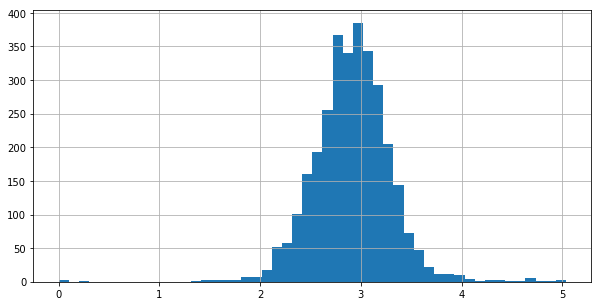

In [165]:
fig, ax = plt.subplots(figsize=(10,5))
danger['storminess'].hist(ax=ax, bins=50);
plt.show()

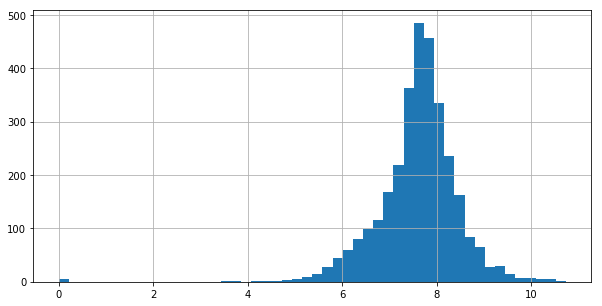

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
danger['log_cost'].hist(ax=ax, bins=50);
# ax.axvline(4, color='r')
# ax.axvline(4, color='r')
# ax.axvline(5, color='r')
# ax.axvline(6, color='r')
# ax.axvline(7, color='r')
# ax.axvline(8, color='r')
# ax.set_xlabel('Log(Number of incidents)')
# ax.set_ylabel('Number of counties')
plt.show()

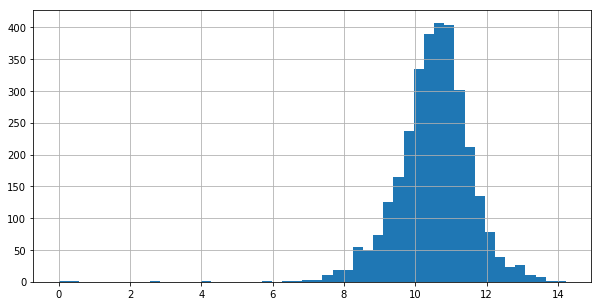

In [167]:
fig, ax = plt.subplots(figsize=(10,5))
danger['badness'].hist(ax=ax, bins=50);
plt.show()

In [168]:
display(danger)

(3141, 12)


,FIPS,geometry,quake_magnitude,tornado_intensity,damage,deaths,injuries,total_storms,overall_cost,storminess,log_cost,badness
0,27077,"POLYGON ((-95.34283127277658 48.546679319076, ...",0.00,3.0,2730200.0,0.000000,4.000000,294,2.930200e+06,2.774517,6.466897,9.241414
1,53019,POLYGON ((-118.8516288013387 47.94956368481996...,0.00,0.0,24320500.0,0.000000,0.000000,251,2.432050e+07,2.401401,7.385973,9.787373
2,53065,"POLYGON ((-117.438831576286 48.04411548512263,...",0.00,2.0,5495500.0,2.666667,10.666667,507,3.002883e+07,2.850033,7.477538,10.327572
3,53047,"POLYGON ((-118.972093862835 47.93915200536639,...",13.35,0.0,392974160.0,15.800000,26.400000,987,5.364942e+08,3.366049,8.729565,12.095614
4,53051,POLYGON ((-117.4385804303028 48.99991850672649...,0.00,0.0,11105000.0,4.666667,13.666667,504,5.378833e+07,2.703291,7.730688,10.433979


# Old cells

In [ ]:
# Export as geoJSON file
dis4.to_file("../data_output/6__danger/danger.geojson", driver='GeoJSON')

In [ ]:
# Export as CSV
dis5 = dis4.drop(columns='geometry')
dis5.to_csv("../data_output/6__danger/danger.csv")

# Generating disaster level labels

In [ ]:
# Histogram to visualize the distribution of danger scores
dis5.hist(bins=50);

Danger levels have a long-tailed distribution, so it's probably better to assign an overall danger score based on the log of danger rather than danger itself.

In [ ]:
# Generate new dataframe
dis6 = dis4.copy()

# Generate new column with the log of danger.
dis6['log_danger'] = np.log(dis6['danger'] + 1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dis6['log_danger'].hist(ax=ax, bins=50);
ax.axvline(4, color='r')
ax.axvline(4, color='r')
ax.axvline(5, color='r')
ax.axvline(6, color='r')
ax.axvline(7, color='r')
ax.axvline(8, color='r')
ax.set_xlabel('Log(Number of incidents)')
ax.set_ylabel('Number of counties')
plt.show()

In [ ]:
# Create an array of numerical bins

danger_bins_numerical = pd.cut(dis6['log_danger'], bins=[0,4,5,6,7,8,12], 
                               include_lowest=True, retbins=False, labels=False)

# Create an array of labeled bins. Intervals are evenly spaced within the 
# log-normal bell curve.
danger_bins_labels = pd.cut(dis6['log_danger'], bins=[0,4,5,6,7,8,12], 
                            include_lowest=True,retbins=True, 
                            labels=['Very Low Risk','Low Risk','Medium Risk',
                                    'High Risk','Very High Risk','Extremely High Risk'])[0]

# Incorporate them into the dataframe
dis6['bins_num'] = danger_bins_numerical
dis6['bins_labels'] = danger_bins_labels

In [ ]:
# All the labels are represented.
dis6.bins_labels.unique()

In [ ]:
dis6.plot(column='bins_num', figsize=(15,6), legend=True);

In [ ]:
dis6[dis6.bins_num == 0].head(30)

In [ ]:
dis7 = dis6[['danger','bins_num','bins_labels']]

# Export as CSV
dis7.to_csv("../data_output/6__danger/danger_labels.csv")